### Light python event model used to simulate Juster events
- liquidity providing risk estimation
- different market maker behaviur testing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

from dynamics import calc_dynamics_by_freq
from coinbase_api import CoinbaseAPI
from plot import plot_dynamics_hists
from user import User
from run_events import run_random_event
from params_generation import generate_params, clipped_normal
from stats import agregate_event_state

sns.set_style("whitegrid")

In [2]:
import sys
sys.path.insert(0, '../../tests')
from event_model import EventModel

### Getting data to use as source of the price dynamics:

In [3]:
api = CoinbaseAPI()

pair = 'XTZ-USD'
event_durations = [3600, 21600, 86400]

dfs = {
    duration: api.get_history_prices(pair=pair, granularity=duration)
    for duration in event_durations
}

dynamics = {
    duration: calc_dynamics_by_freq(dfs[duration], f'{duration}S')
    for duration in event_durations
}

### Current data distribution:

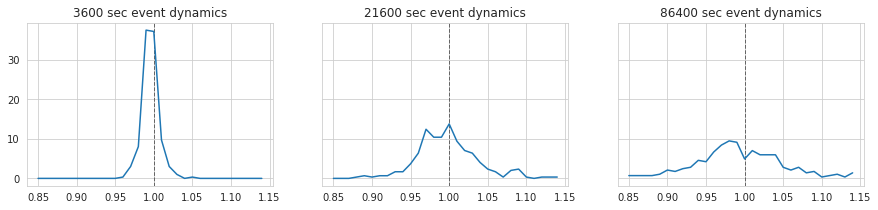

In [4]:
axes = plot_dynamics_hists(dynamics)

### Assumptions:

#### 1. Liquidity providers:
- there are two providers: one that adds liquidity in the event creation and second in random time during event (time selected using uniform distribution)
- first provider have expected market ratio that calculated as 

#### 2. Market expectation model:
- market ratio expectations are composed of different users expected ratio value
- users expected ratio value calculated before event creation and kept constant during event
- mean users expected ratio is equal to the real market ratio

#### 3. Users actions:
- user bets values are distributed exponentially
- bet pool is decided by difference between event pool and user expected pool
- MAYBE: user makes K bets proposals and selects one that leads event to the have the most close ratio to the user expectations (TODO: check this one, but I feel that it would change bet distribution)

## WIP
### TODO: process collected data: agregate, calculate stats
### TODO: collect metadata during event about bets and other params
### TODO: include DAO profit fee somewhere
### TODO: save data (?)
### TODO: analyze data to answer questions
- maybe using dash or another BI? find a way to make it interactive, so it would be easy to calculate mean event results

### ? TODO:
- make separate table with users ratio expecatations?

### To calculate expected market outcome for provider / users "clipped normal distribution" used, it looks like this:

<AxesSubplot:>

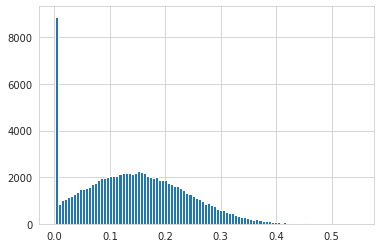

In [5]:
market_dynamics = dynamics[3600]
target_dynamics = 1.01

market_ratio = (market_dynamics >= target_dynamics).mean()
pd.Series(clipped_normal(market_ratio, 0.1, 100000)).hist(bins=100)

### TODO: there can be problems with event with analysing rates that too different from market ratio
- either need to change clipped_normal model
- either need to be very careful with events where target is not 0.5 and providers with big error rate
- but maybe it is OK, because if provider have big error: he suffers

### Running generation:

In [6]:
market_dynamics = dynamics[3600]
target_dynamics = 1.00
iterations = 100_000
results = []


for _ in tqdm(range(iterations)):
    params = generate_params(market_dynamics, target_dynamics)
    event_state = run_random_event(**params).to_dict()
    stats = agregate_event_state(event_state)

    results.append({
        **params,
        **event_state,
        **stats
    })

df = pd.DataFrame(results)

100%|██████████| 100000/100000 [06:43<00:00, 247.61it/s]


In [22]:
import json
import gzip

class EventSimulationData:
    def __init__(self, results):

        self.results = results
        self.df = pd.DataFrame(results)

    @classmethod
    def load(cls, filename):

        with gzip.open(filename, 'rt', encoding="ascii") as zipfile:
            json_bytes = zipfile.read()
            results = json.loads(json_bytes)

        return EventSimulationData(results)

    def save(self, filename):
        with gzip.open(filename, 'wt', encoding="ascii") as zipfile:
            json.dump(self.results, zipfile)

<AxesSubplot:>

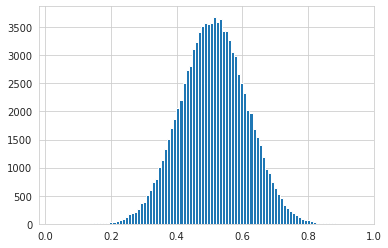

In [23]:
df.primary_provider_expected_a.hist(bins=100)

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ticks,100000.0,1.000000e+03,0.000000e+00,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
bet_chance,100000.0,1.002443e-01,5.745814e-02,1.003855e-03,5.039360e-02,1.001513e-01,1.500268e-01,1.999998e-01
users_count,100000.0,5.048241e+01,2.833426e+01,2.000000e+00,2.600000e+01,5.000000e+01,7.500000e+01,9.900000e+01
actual_dynamics,100000.0,1.000209e+00,1.058393e-02,9.693998e-01,9.936546e-01,1.000176e+00,1.005634e+00,1.050086e+00
target_dynamics,100000.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
fee,100000.0,1.943153e-02,1.759807e-02,0.000000e+00,5.000000e-03,1.000000e-02,3.000000e-02,5.000000e-02
primary_provider_amount,100000.0,9.990926e+07,9.978291e+07,5.912776e+02,2.878243e+07,6.881173e+07,1.392990e+08,1.423586e+09
primary_provider_expected_a,100000.0,5.116067e-01,1.006391e-01,2.900548e-02,4.437674e-01,5.117033e-01,5.793962e-01,9.554187e-01
primary_provider_expected_a_ape,100000.0,1.570149e-01,1.184344e-01,2.738154e-06,6.304270e-02,1.325313e-01,2.265349e-01,9.433161e-01
following_provider_amount,100000.0,9.984143e+07,9.998611e+07,7.305425e+02,2.848176e+07,6.888571e+07,1.390175e+08,1.189186e+09


### Support stat/filter funcs:

In [132]:
def filter_q(df, field, q=0.001):
    """ returns dataframe with excluded extreme q values,
        good to have anomaly values removed """

    series = df[ field ]
    is_above_low_q = series > series.quantile(q)
    is_bellow_high_q = series < series.quantile(1-q)
    return df[ is_above_low_q & is_bellow_high_q ]


def agg_stats_by_selector(df, selector):

    aggs = ['mean', 'median', 'min', 'max']
    stats = df.groupby(selector)['primary_provider_result'].agg(aggs)
    stats = stats.rename(columns=lambda c: f'{c}_result')
    stats['profitable_events_rate'] = df.groupby(selector).primary_provider_is_profit.mean()
    return stats

### Calculating more stats:

In [134]:
df['primary_provider_result'] = df['diff_primary_provider'] / df['primary_provider_amount']
df['following_provider_result'] = df['diff_following_provider'] / df['following_provider_amount']

df['primary_provider_is_profit'] = df['diff_primary_provider'] > 0
df['primary_provider_is_loss'] = df['diff_primary_provider'] < 0
df['following_provider_is_profit'] = df['diff_following_provider'] > 0
df['following_provider_is_loss'] = df['diff_following_provider'] < 0

df['total_liquidity'] = df['pool_a'] * df['pool_b'] / 10**12

In [177]:
def add_bins(df, field, bins_count=10, round_max_digits=0, spacer=np.linspace):

    bins = spacer(df[field].min(), df[field].max(), bins_count)
    cats = pd.cut(df[field], bins=bins)
    df[f'{field}_bin_left'] = cats.map(lambda x: x.left)
    df[f'{field}_bin_right'] = cats.map(lambda x: x.right)
    df[f'{field}_bin_group'] = cats.map(lambda x: f'{x.left} - {x.right}')

    return df

In [182]:
df = add_bins(df, 'bet_chance', bins_count=11, round_max_digits=2)
df = add_bins(df, 'total_liquidity', bins_count=9, round_max_digits=-5)
df = add_bins(df, 'following_provider_to_primary_shares', bins_count=5, spacer=np.geomspace)
df = add_bins(df, 'primary_provider_amount', bins_count=10, spacer=np.geomspace)

In [183]:
# very strange values:
df['following_provider_to_primary_shares_bin_group'].value_counts()

0.156 - 22.345        85185
0.00109 - 0.156       13464
22.345 - 3205.336      1230
7.57e-06 - 0.00109      120
Name: following_provider_to_primary_shares_bin_group, dtype: int64

In [185]:
df['primary_provider_amount_bin_right'].value_counts().sort_index()

3025.919              2
15485.421            14
79248.092            62
405559.525          306
2075488.814        1680
10621508.194       8015
54356561.972      32081
278174791.704     51654
1423585523.657     6185
Name: primary_provider_amount_bin_right, dtype: int64

## Questions:

### How does fee affects liquidity provider returns?
- what are expected provider return with different fees?
- what are chance to have loss with different fees?

In [186]:
fee_stats = agg_stats_by_selector(df, 'fee')
fee_stats

,mean_result,median_result,min_result,max_result,profitable_events_rate
fee,,,,,
0.000,0.142720,-0.001162,-0.984442,1296.333251,0.495263
0.001,0.074497,0.004602,-0.920416,87.871316,0.507035
0.005,0.202603,0.029269,-0.797832,181.817728,0.551417
0.010,0.359558,0.048807,-0.912092,685.072079,0.580474
0.020,1.643911,0.079438,-0.801340,9356.928288,0.630834
0.030,0.954872,0.102315,-0.825901,3292.172419,0.666020
0.040,1.211998,0.135500,-0.809572,1065.873038,0.700403
0.050,2.489520,0.157468,-0.880883,13695.216527,0.732637


<AxesSubplot:ylabel='fee'>

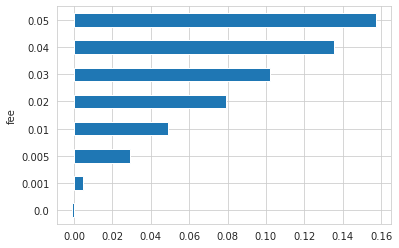

In [187]:
fee_stats.median_result.plot.barh()

### How liquidity provider error affects his returns?

- absolute percent error distribution:

<AxesSubplot:>

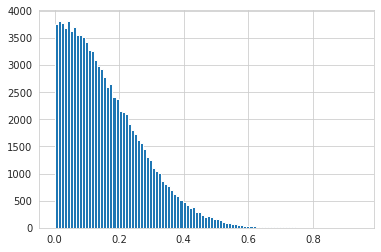

In [188]:
df['primary_provider_expected_a_ape'].hist(bins=100)

<AxesSubplot:xlabel='primary_provider_expected_a_ape', ylabel='primary_provider_result'>

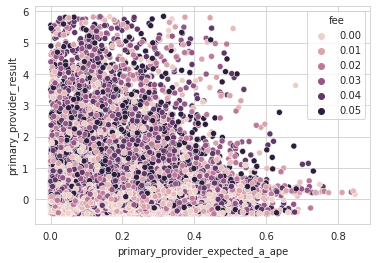

In [189]:
sns.scatterplot(
    data=filter_q(df, 'primary_provider_result', 0.01),
    x='primary_provider_expected_a_ape',
    y='primary_provider_result',
    hue='fee'
)

### How bet density affects provider returns?

In [190]:
bet_chance_stats = agg_stats_by_selector(df, 'bet_chance_bin_right')

<AxesSubplot:ylabel='bet_chance_bin_right'>

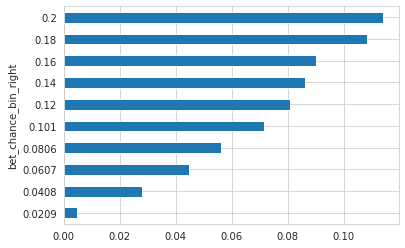

In [191]:
bet_chance_stats.median_result.plot.barh()

In [192]:
liquidity_stats = agg_stats_by_selector(df, 'total_liquidity_bin_right')

<AxesSubplot:ylabel='total_liquidity_bin_right'>

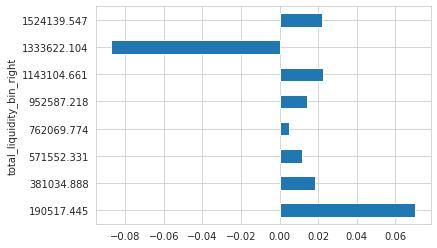

In [193]:
liquidity_stats.median_result.plot.barh()

### What else heavily affects provider returns?

In [194]:
target = 'primary_provider_result'

result_corr = df.corr().loc[ target ].drop(target)
result_corr_df = pd.DataFrame({
    'corr': result_corr,
    'corr_abs': result_corr.abs()
})

result_corr_df.sort_values('corr_abs', ascending=False)

,corr,corr_abs
primary_provider_amount,-0.014554,0.014554
primary_provider_is_profit,0.014281,0.014281
primary_provider_is_loss,-0.014231,0.014231
fee,0.012211,0.012211
pool_b,-0.011545,0.011545
pool_a,-0.011243,0.011243
bet_chance,0.010943,0.010943
diff_primary_provider,0.009714,0.009714
total_liquidity,-0.007719,0.007719
diff_user_q0_99,0.006150,0.006150


### Why primary_provider_amount is so impactive?

In [196]:
provided_amount_stats = agg_stats_by_selector(df, 'primary_provider_amount_bin_right')
provided_amount_stats

,mean_result,median_result,min_result,max_result,profitable_events_rate
primary_provider_amount_bin_right,,,,,
3025.919,4823.353945,4823.353945,289.779602,9356.928288,1.000000
15485.421,1436.489997,807.875753,11.628209,4943.837626,1.000000
79248.092,183.682178,88.009679,-0.949172,1702.498759,0.887097
405559.525,31.859322,16.941629,-0.984442,339.496704,0.905229
2075488.814,5.876022,2.547168,-0.957055,67.159649,0.863095
10621508.194,0.956994,0.380983,-0.920416,25.355581,0.759950
54356561.972,0.151593,0.102474,-0.827401,5.812083,0.647237
278174791.704,0.025905,0.031703,-0.820633,1.230324,0.558814
1423585523.657,-0.001307,0.013154,-0.597580,1.800046,0.526435


WOW: looks like the less liquidity provided - the more profits

### more questions:
- Does users market expectance variance affect provider returns?
- How liquidity provider profit depends from bets frequency / size?
- What difference between risks and profits of the primary and the folowing providers?
- What are expected profits for providers for providers with different fees amount?
    - mean, median, q1 and q99 profits
- What mean APY is generated by events and is it possible to make APY predictions using expected market activity params?

### Modelling:

In [154]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [155]:
X = df.dropna()
y = X.primary_provider_result
X = X[[
    'primary_provider_amount',
    'fee',
    'pool_a',
    'bet_chance',
    'bet_ratio_deviation',
    'users_count',
    'following_provider_amount',
    'actual_dynamics',
    'primary_provider_expected_a_ape',
    'primary_provider_expected_a'
]]

# TODO: primary_provider_is_profit classifier

In [156]:
# TODO: cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [159]:
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_train, y_train)

0.9108345190931819

In [160]:
regr.score(X_test, y_test)

0.5918283984740185

In [163]:
# feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = pd.Series(regr.feature_importances_, index=X.columns)
importances

primary_provider_amount            0.818578
fee                                0.014051
pool_a                             0.014670
bet_chance                         0.035919
bet_ratio_deviation                0.004359
users_count                        0.061419
following_provider_amount          0.008681
actual_dynamics                    0.017153
primary_provider_expected_a_ape    0.015718
primary_provider_expected_a        0.009452
dtype: float64